## K means Implementation

Loading some libraries

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from scipy import  misc

A method to extract feature space according to type of feature 

In [3]:
def extract_feature_space(image, d):
    '''
    inputs:
        image : the image itself
        feature : intensity(1D), color(HS) (2D) or color(RGB)(3D)
    outputs:
        feature vector.
    '''
    m, n = image.shape[0:2]
    hsv_image = colors.rgb_to_hsv(image)
    num_points = m*n
    if d == 1:
        im_space = hsv_image[...,2]
    elif d == 2:
        im_space = hsv_image[...,0:2]
    elif d == 3:
        im_space = image
    else:
        exit('Not supported feature')
    # Feature space extraction. It is just reshape operation
    feature_vector = np.reshape(im_space, (num_points,d)).T
    return feature_vector

Extract results of clustering by assigning the cluster center to all its points and returning back to image space

In [4]:
def extract_segmented_image(clustering_out, clusters, image):
    '''
    inputs:
        clustering_out: a 1D lookup table for each pixel cluster pair (size -> 1 x num_points)
        clusters: a lookup table for cluster feature pair (size -> k x d) where 
        k is number of clusters and d is feature dimension 
    output: 
        segmented Image (in image domain)
    '''
    m, n = image.shape[0:2]
    d, k = clusters.shape[0:2]
    clusterd_feature_space = np.zeros((len(clustering_out),clusters.shape[0])).T
     # Now assign values to pixels according to its cluster
    for c in range(k):
        idxs = np.where(clustering_out == c)
        for j in idxs[0]:
            clusterd_feature_space[:,j] = clusters[:,c]
    # Return to image space     
    im_space  = np.reshape(clusterd_feature_space.T, (m, n,d))
    if d == 1:
        im_space = im_space[...,0]
        segmented_image = im_space
    elif d == 2:
         hsv_image = colors.rgb_to_hsv(image)
         hsv_image[...,0:2] = im_space
         hsv_image[..., 2] /= np.max(hsv_image[...,2])
         segmented_image = colors.hsv_to_rgb(hsv_image)
    else:
        segmented_image = im_space
    return segmented_image

K means function

In [5]:
def kmeans(image, k, num_iterations, d):
    '''
    inputs : 
    image 
    k : number of clusters 
    num_iterations :  number of iterations
    d : dimension of feature space 1, 2, or 3D
    '''
    #1. Construnct feature space
    m, n = image.shape[0:2]
    num_points = m*n
    #We will select H and S channels (color information)
    # We have 2D feature space
    feature_space = extract_feature_space(image, d)
    # 2. Getting Initial centers 
    idxs = np.round(num_points * np.random.rand(k))
    #Boundary condition
    idxs[np.where(idxs >= m*n)] -= 1
    initial_centers = np.zeros((d,k))
    for i in range(k):
        initial_centers[:,i] = feature_space[:,int(idxs[i])]
    clusters_centers = initial_centers
    # Initialize distance vector 
    distance = np.zeros((k,1))
    #cluster points determines cluster of each point in space
    cluster_points = np.zeros((num_points, 1))
    #3 - start clustering for number of iterations
    for j in range(num_iterations):
        #Cluster all points according min distance
        for l in range(num_points):
            #Get distance to all centers 
            for h in range(k):
                distance[h] = np.sqrt(np.sum((feature_space[:,l]-clusters_centers[:,h])**2))
            #Select minimum one
            cluster_points[l] = np.argmin(distance)
        # Update centers of clusters according new points 
        for c in range(k):
            # Get points associated with that cluster
            idxs = np.where(cluster_points == c)
            points = feature_space[:,idxs[0]]
            # Get its new center 
            # Avoid division by zero
            if points.size > 0:
                clusters_centers[:,c] = np.mean(points, 1)
            else:
                idx =  np.round(num_points * np.random.rand())
                clusters_centers[:,c] = feature_space[:,int(idx)]
        segmented_image = extract_segmented_image(cluster_points, clusters_centers, image)
        return segmented_image

Lets Test it for 1D feature space

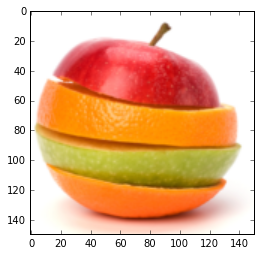

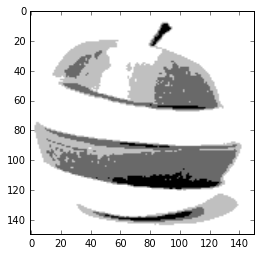

In [6]:
#Load the image
image = plt.imread('images/seg3.png')
# Rescale image down for speedup    
image = misc.imresize(image, (150,150))
#Show original Image
plt.figure('Original Image')
plt.imshow(image)
#Apply k means segmentation and show the result
segmented_image = kmeans(image, 5,10, 1)
plt.figure('segmented image')
plt.set_cmap('gray')
plt.imshow(segmented_image)

2D feature space 

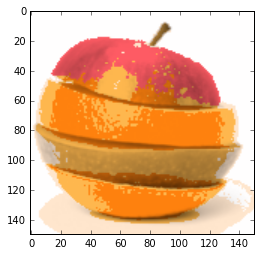

In [12]:
segmented_image = kmeans(image, 5,10, 2)
plt.figure('segmented image')
plt.set_cmap('gray')
plt.imshow(segmented_image)

3D feature space

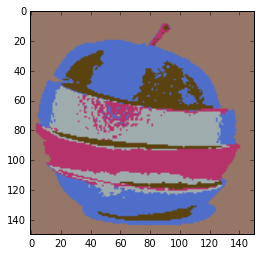

In [13]:
segmented_image = kmeans(image, 5,10, 3)
plt.figure('segmented image')
plt.set_cmap('gray')
plt.imshow(segmented_image)